# PCA City Lifestyle Patterns and NMF Review Topics

This notebook demonstrates PCA for dimensionality reduction and NMF for topic modeling on text reviews.

### Project Overview
- Goal: identify lifestyle patterns using PCA and discover review themes using NMF
- Approach: PCA (structured data), TF-IDF and NMF (text data)

### Datasets
- ``city_lifestyle_dataset.csv`` (structured features)
- ``reviews_data.csv`` (text reviews)

### Key Outputs
- PCA explained variance and loadings interpretation
- PC1–PC2 scatter plots (country/cluster)
- NMF topics with top keywords and labels

## Setup

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import spacy

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer

sns.set_theme(style="whitegrid")

# Part 1: Dimensionality Reduction and Pattern Discovery Using PCA

## Data exploration and data quality checks 
This section checks data quality before modelling:
- Missing values
- Duplicated rows
- Inconsistent / out-of-range values

In [7]:
df = pd.read_csv("data/city_lifestyle_dataset.csv")
df.head()

,city_name,country,population_density,avg_income,internet_penetration,avg_rent,air_quality_index,public_transport_score,happiness_score,green_space_ratio
0,Old Vista,Europe,2775,3850,86.4,1310,43,52.0,8.5,23.8
1,Beachport,Europe,3861,3700,78.1,1330,42,62.8,8.1,33.1
2,Valleyborough,Europe,2562,4310,80.1,1330,39,73.2,8.5,40.2
3,City,Europe,3192,3970,81.2,1480,60,49.2,8.5,43.6
4,Falls,Europe,3496,4320,100.0,1510,64,93.7,8.5,42.5


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city_name               300 non-null    object 
 1   country                 300 non-null    object 
 2   population_density      300 non-null    int64  
 3   avg_income              300 non-null    int64  
 4   internet_penetration    300 non-null    float64
 5   avg_rent                300 non-null    int64  
 6   air_quality_index       300 non-null    int64  
 7   public_transport_score  300 non-null    float64
 8   happiness_score         300 non-null    float64
 9   green_space_ratio       300 non-null    float64
dtypes: float64(4), int64(4), object(2)
memory usage: 23.6+ KB


In [9]:
#df.describe().T
num_cols = df.select_dtypes(include=[np.number]).columns
display(df[num_cols].describe().T)

,count,mean,std,min,25%,50%,75%,max
population_density,300.0,3944.843333,2982.566777,100.0,1830.000,3083.5,4823.750,14427.0
avg_income,300.0,2827.200000,1201.163939,480.0,1907.500,2810.0,3752.500,5720.0
internet_penetration,300.0,74.305333,17.014492,34.0,64.400,75.0,87.225,100.0
avg_rent,300.0,1002.766667,456.282066,170.0,640.000,990.0,1332.500,2430.0
air_quality_index,300.0,71.246667,25.344961,22.0,54.000,67.5,86.000,146.0
public_transport_score,300.0,55.717333,14.712549,15.0,46.075,54.7,64.200,95.0
happiness_score,300.0,6.644000,1.685864,2.5,5.300,6.9,8.500,8.5
green_space_ratio,300.0,33.993333,9.434067,2.0,28.225,34.7,40.400,58.0


In [10]:
df.shape

(300, 10)

In [11]:
print("Missing values per column:")
display(df.isna().sum())

Missing values per column:


city_name                 0
country                   0
population_density        0
avg_income                0
internet_penetration      0
avg_rent                  0
air_quality_index         0
public_transport_score    0
happiness_score           0
green_space_ratio         0
dtype: int64

In [12]:
print("\nNumber of duplicated rows:", df.duplicated().sum())


Number of duplicated rows: 0


### Observations
- From df.shape, this dataset consists of 300 rows and 10 columns.
- **Missing values:** From df.info() and df.isna().sum(), no missing values were found in the city lifestyle dataset.
- **Duplicates:** From df.duplicated().sum(), no duplicated rows were detected.
- **Numeric value checks:** Based on df.describe(), the numerical columns showed reasonable minimum/maximum values and reasonable rangess. No obvious anomalies (e.g., negative values where not expected, extreme outliers, or impossible ranges) were observed.

**Conclusion:** Since no data quality problems were detected, no preprocessing fixes were required.

## Apply PCA and identify main factors 

In [15]:
X = df.drop(columns=["city_name", "country"])
X.head()

,population_density,avg_income,internet_penetration,avg_rent,air_quality_index,public_transport_score,happiness_score,green_space_ratio
0,2775,3850,86.4,1310,43,52.0,8.5,23.8
1,3861,3700,78.1,1330,42,62.8,8.1,33.1
2,2562,4310,80.1,1330,39,73.2,8.5,40.2
3,3192,3970,81.2,1480,60,49.2,8.5,43.6
4,3496,4320,100.0,1510,64,93.7,8.5,42.5


*city_name* and *country* were excluded because they are identifiers rather than lifestyle measurements. PCA operates on numeric features and their variance structure, so the analysis was performed using only the numeric lifestyle variables to extract the dominant factors shaping city profiles.

In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df.head()

,population_density,avg_income,internet_penetration,avg_rent,air_quality_index,public_transport_score,happiness_score,green_space_ratio
0,-0.392882,0.852930,0.712033,0.674466,-1.116351,-0.253086,1.102759,-1.082287
1,-0.028158,0.727843,0.223398,0.718372,-1.155872,0.482207,0.865095,-0.094850
2,-0.464417,1.236532,0.341141,0.718372,-1.274437,1.190268,1.102759,0.658999
3,-0.252836,0.953000,0.405900,1.047665,-0.444485,-0.443718,1.102759,1.019997
4,-0.150740,1.244871,1.512687,1.113524,-0.286399,2.585965,1.102759,0.903203


``StandardScaler`` was used to standardise the features, and the table above shows the resulting scaled values where each column is centred around 0 and scaled to a similar spread. This matters because PCA is driven by variance. If some variables have much larger numeric values, they will produce larger variance and dominate the principal components. If we do not standardise, PCA will mostly reflect the biggest scale variables instead of the overall lifestyle patterns across all features.

In [19]:
# Trial and error for n components 1 to 3
for k in range(1, 4):
    pca_k = PCA(n_components=k, random_state=42)
    pca_k.fit(X_scaled)

    var_ratio = pca_k.explained_variance_ratio_
    total_var = var_ratio.sum()

    print("n_components =", k)
    print("Explained variance ratio per PC", var_ratio)
    print("Total explained variance", total_var)

n_components = 1
Explained variance ratio per PC [0.53805804]
Total explained variance 0.5380580421758271
n_components = 2
Explained variance ratio per PC [0.53805804 0.25833116]
Total explained variance 0.7963892000125801
n_components = 3
Explained variance ratio per PC [0.53805804 0.25833116 0.07327942]
Total explained variance 0.8696686211986314


**Explained variance:** <br>
PC1 explained 53.8% and PC2 explained 25.8%, for a cumulative 79.6%. Two components captured most of the variability while keeping the representation easy to visualise. Using three components increased the cumulative explained variance to about 86.97%, but the additional gain was smaller relative to the added complexity, so n_components = 2 was used for the main analysis.

In [21]:
# Choose n components = 2
pca = PCA(n_components=2, random_state=42)
PC_scores = pca.fit_transform(X_scaled)

In [22]:
loadings = pd.DataFrame(
    pca.components_.T,
    index=X.columns,
    columns=["PC1", "PC2"]
)

display(loadings)

,PC1,PC2
population_density,-0.176986,0.574718
avg_income,0.452965,0.144767
internet_penetration,0.407390,0.185860
avg_rent,0.440567,0.135761
air_quality_index,-0.329965,0.373182
public_transport_score,0.264291,0.427516
happiness_score,0.462680,-0.077554
green_space_ratio,0.103120,-0.517414


In [23]:
top_pc1 = loadings["PC1"].abs().sort_values(ascending=False).head(5)
top_pc2 = loadings["PC2"].abs().sort_values(ascending=False).head(5)

print("Top 5 contributors to PC1:")
display(top_pc1)

print("\nTop 5 contributors to PC2:")
display(top_pc2)

Top 5 contributors to PC1:


happiness_score         0.462680
avg_income              0.452965
avg_rent                0.440567
internet_penetration    0.407390
air_quality_index       0.329965
Name: PC1, dtype: float64


Top 5 contributors to PC2:


population_density        0.574718
green_space_ratio         0.517414
public_transport_score    0.427516
air_quality_index         0.373182
internet_penetration      0.185860
Name: PC2, dtype: float64

### Interpretation
Loadings can flip sign without changing the geometry of PCA, so interpretation focuses on variables with larger absolute loadings and their co movement.

**First Principal Component (PC1)**
PC1 is mainly driven by *happiness_score*, *avg_income*, *avg_rent*, and *internet_penetration* with the opposite direction coming from *air_quality_index*. This axis can be interpreted as a socio-economic and well-being factor where cities with higher income, higher rent, higher connectivity, and higher happiness are separated from cities with higher air quality index values.

**Second Principal Component (PC2)**
PC2 is mainly driven by *population_density* and *public_transport_score* in one direction, and *green_space_ratio* in the opposite direction. Air quality index also contributes in the same direction as *population_density* and *public_transport_score*. This axis can be interpreted as an urban form factor that separates dense and transit-oriented cities from greener cities with a higher green space ratio.

**Key lifestyle factors captured by PCA** 
- Economic and cost of living factors: income and rent 
- Connectivity factor: internet penetration 
- Well-being factor: happiness score 
- Urban environment and structure factor: density, public transport, air quality index, and green space ratio 

## PCA visualisation and cluster summary
Cities were projected into the **PC1–PC2 space** to explore patterns in the reduced representation.  
To summarise groups in this space, **KMeans clustering** was applied to the PCA scores and clusters were described using the original feature averages.


In [26]:
pca_df = pd.DataFrame(PC_scores, columns=["PC1", "PC2"])
pca_df["city_name"] = df["city_name"].values
pca_df["country"] = df["country"].values
pca_df.head()

,PC1,PC2,city_name,country
0,1.743192,0.071251,Old Vista,Europe
1,1.641493,-0.014981,Beachport,Europe
2,2.411046,-0.320204,Valleyborough,Europe
3,1.748150,-0.758528,City,Europe
4,3.078707,0.971714,Falls,Europe


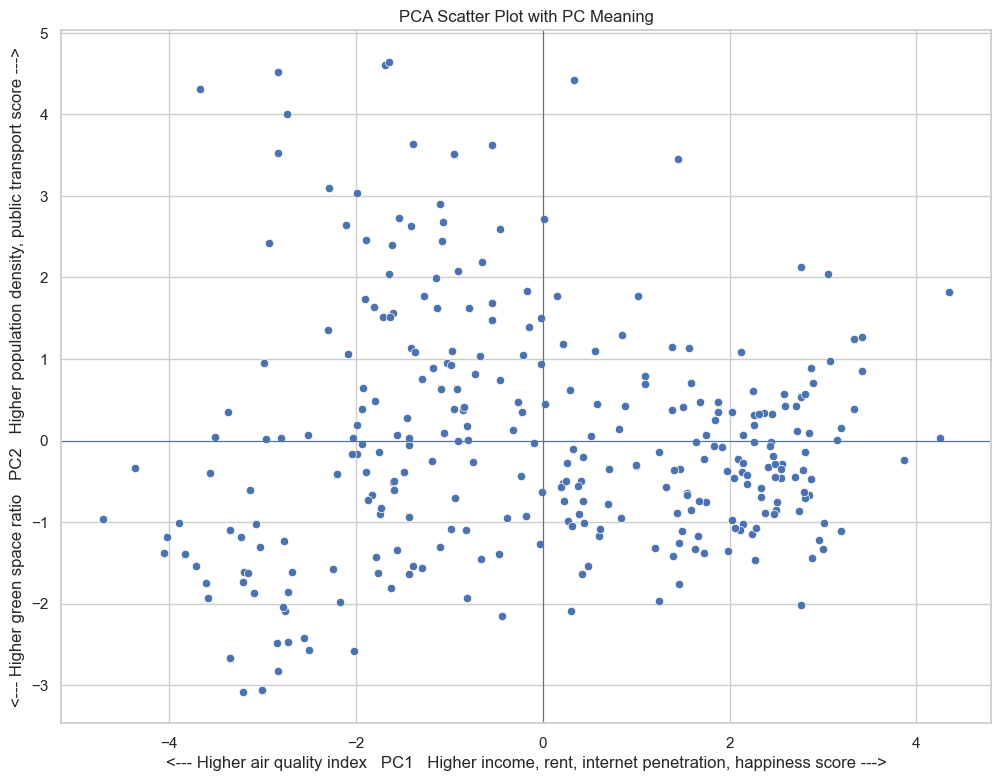

In [27]:
plt.figure(figsize=(12, 9))
sns.scatterplot(x="PC1", y="PC2", data=pca_df)
plt.xlabel("<--- Higher air quality index   PC1   Higher income, rent, internet penetration, happiness score --->")
plt.ylabel("<--- Higher green space ratio   PC2   Higher population density, public transport score --->")
plt.axhline(0, linewidth=0.8)
plt.axvline(0, linewidth=0.8)
plt.title("PCA Scatter Plot with PC Meaning")
plt.show()

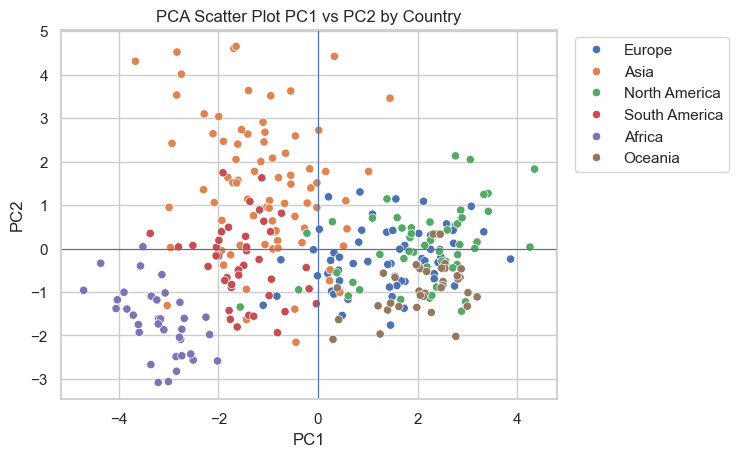

In [28]:
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="country")
plt.title("PCA Scatter Plot PC1 vs PC2 by Country")
plt.axhline(0, linewidth=0.8)
plt.axvline(0, linewidth=0.8)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.show()

In [29]:
display(pca_df.groupby("country")[["PC1", "PC2"]].mean().sort_values("PC1"))

,PC1,PC2
country,,
Africa,-3.185934,-1.688824
South America,-1.500977,-0.310241
Asia,-1.105422,1.428621
Europe,1.366542,-0.225940
Oceania,2.082175,-0.930302
North America,2.102236,0.066915


The PCA scatter plot coloured by country showed visible grouping trends across regions. North America, Europe, and Oceania tended to appear on the positive side of PC1, while Africa, South America, and Asia tended to appear on the negative side. Since PC1 represents higher income, rent, internet penetration, and happiness on the positive side, this suggests these factors are generally higher for the right side groups and lower for the left side groups.

PC2 adds a second difference in urban form. Asia tends to have higher PC2 values, meaning it is more associated with higher population density and public transport, while Africa and Oceania tend to have lower PC2 values, which aligns more with higher green space ratio. The country mean table supports this pattern, with Africa having the lowest average PC1 and PC2, and North America having the highest average PC1.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

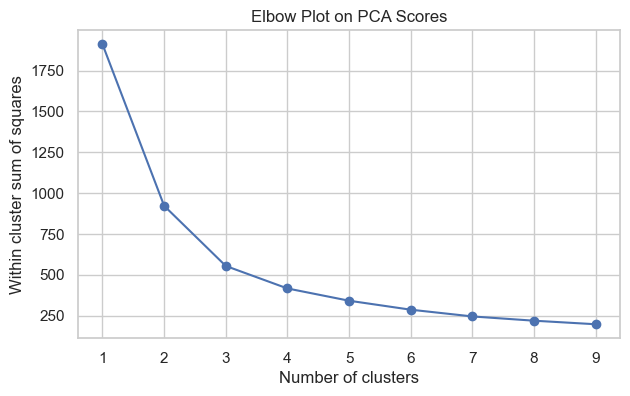

In [31]:
# Elbow method
ssw = []
clusters = range(1, 10)

for k in clusters:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(pca_df[["PC1", "PC2"]])
    ssw.append(km.inertia_)

plt.figure(figsize=(7, 4))
plt.plot(clusters, ssw, marker="o")
plt.xlabel("Number of clusters")
plt.ylabel("Within cluster sum of squares")
plt.title("Elbow Plot on PCA Scores")
plt.show()

In [32]:
# KMeans clustering on PCA scores 
# Test a few k values using silhouette score (higher is better)
sil_scores = {}
for k in [2, 3, 4]:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(pca_df[["PC1","PC2"]])
    sil_scores[k] = silhouette_score(pca_df[["PC1","PC2"]], labels)

display(pd.DataFrame({"k": list(sil_scores.keys()), "silhouette": list(sil_scores.values())}).sort_values("silhouette", ascending=False))

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


,k,silhouette
1,3,0.487458
0,2,0.467125
2,4,0.421619


The elbow plot shows a clear bend at k = 3, and k = 3 also gives the highest silhouette score among the tested values. KMeans with k=3 was used as a lightweight grouping step to describe separation in PC space.

In [34]:
# Choose k=3 (best among tested here)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
pca_df["cluster"] = kmeans.fit_predict(pca_df[["PC1","PC2"]])

display(pca_df["cluster"].value_counts().sort_index())

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


cluster
0     70
1    143
2     87
Name: count, dtype: int64

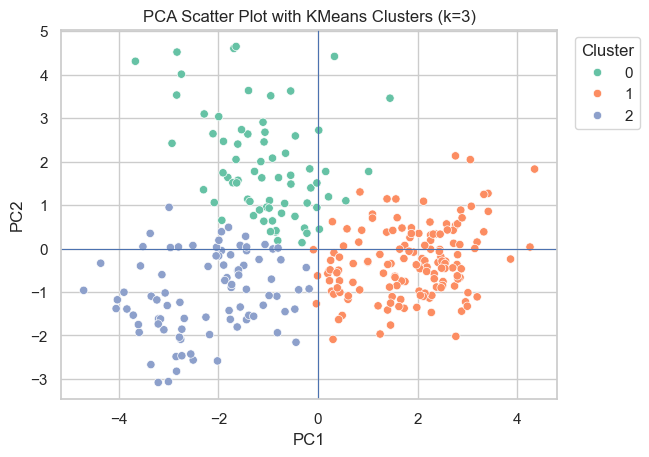

In [35]:
# Plot clusters in PCA space
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="cluster", palette="Set2")
plt.title("PCA Scatter Plot with KMeans Clusters (k=3)")
plt.axhline(0, linewidth=0.8)
plt.axvline(0, linewidth=0.8)
plt.legend(title="Cluster", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.show()

In [36]:
# cluster distribution by country
df_clustered = df.copy()
df_clustered["cluster"] = pca_df["cluster"]
display(pd.crosstab(df_clustered["country"], df_clustered["cluster"]))

cluster,0,1,2
country,,,
Africa,0,0,35
Asia,60,5,15
Europe,2,55,3
North America,1,47,2
Oceania,0,35,0
South America,7,1,32


In [37]:
# Cluster profiling using original features
cluster_summary = df_clustered.groupby("cluster")[num_cols].mean().round(2)
display(cluster_summary)

,population_density,avg_income,internet_penetration,avg_rent,air_quality_index,public_transport_score,happiness_score,green_space_ratio
cluster,,,,,,,,
0,8245.63,2550.71,73.08,895.29,97.00,63.51,5.63,25.09
1,2367.34,3804.06,86.26,1361.54,53.76,60.76,8.15,37.08
2,3077.36,1444.02,55.64,499.54,79.26,41.17,4.97,36.08


### Interpretations
**Cluster behaviour (KMeans on PCA scores, k = 3):**<br>
Using the cluster means, the clusters can be summarized as:

**Cluster 1 (Higher income + higher happiness + high connectivity):**
- Higher *avg_income*, *avg_rent*, *internet_penetration* and *happiness_score*.
- Lower *air_quality_index* and*population_density*.
- Interpreted as **more affluent and higher-quality-of-life cities**.

**Cluster 0 (Very dense + worse air + strong transport):**
- Very high *population_density*, higher *air_quality_index* and *public_transport_score*.
- Lower *avg_income* and *green_space_ratio*.
- Interpreted as **highly urbanised cities with stronger transit but higher environmental pressure**.

**Cluster 2 (Lower connectivity + lower income + weaker transport):**
- Lower *avg_income*, lower *internet_penetration*, and lower *public_transport_score*.
- Moderate *population_density* and relatively higher *green_space_ratio* compared to cluster 0.
- Interpreted as **less connected and lower cost lifestyle profiles**.

**Conclusion:** City lifestyles are mainly shaped by economic factors (income, rent), digital connectivity (internet penetration), well being (happiness), and urban environment (density, transport, air quality, green space).


# Part 2: Topic Modelling on Reviews Dataset Using NMF

## Text preprocessing 
Topic modelling requires text to be converted into a clean numerical representation. The following preprocessing steps were applied

1. **Lowercasing**: standardises words so "Good" and "good" are treated as the same token
2. **Remove bracketed content in square brackets []**: removes references or metadata that do not describe the review topic
3. **Remove punctuation and special characters**: reduces noise and keeps only meaningful word tokens for topic discovery
4. **Stopword removal** removes very common words such as "the", "and", which do not help differentiate topics
5. **Normalization using lemmatization**: converts words into their base form such as "ordering", "ordered" to "order" so similar word variants are grouped together to improve topic consistency and topic interpretability

In [41]:
nlp = spacy.load("en_core_web_sm")

In [42]:
# helper functions from text preprocessing section
def lower_replace(series):
    output = series.str.lower() #ensure that it is converted to lowercase
    output = output.str.replace(r'\[.*?\]', '', regex=True) #to remove the source in square bracket and replace with empty string
    output = output.str.replace(r'[^\w\s]', '', regex=True) # to remove not alphabets (not useful for clustering) but for sentimal analysis is useful
    return output

#convert text to basic form
def token_lemma_nonstop(text):
    doc = nlp(text)
    output = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(output)

def clean_and_normalize(series):
    output = lower_replace(series)
    output = output.apply(token_lemma_nonstop)
    return output

In [43]:
df2 = pd.read_csv("data/reviews_data.csv")
df2.head()

,name,location,Date,Rating,Review,Image_Links
0,Helen,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.0,Amber and LaDonna at the Starbucks on Southwes...,['No Images']
1,Courtney,"Apopka, FL","Reviewed July 16, 2023",5.0,** at the Starbucks by the fire station on 436...,['No Images']
2,Daynelle,"Cranberry Twp, PA","Reviewed July 5, 2023",5.0,I just wanted to go out of my way to recognize...,['https://media.consumeraffairs.com/files/cach...
3,Taylor,"Seattle, WA","Reviewed May 26, 2023",5.0,Me and my friend were at Starbucks and my card...,['No Images']
4,Tenessa,"Gresham, OR","Reviewed Jan. 22, 2023",5.0,I’m on this kick of drinking 5 cups of warm wa...,['https://media.consumeraffairs.com/files/cach...


In [44]:
df2.shape

(850, 6)

In [45]:
# missing values per column
df2.isna().sum()

name             0
location         0
Date             0
Rating         145
Review           0
Image_Links      0
dtype: int64

Missing values were not imputed because they appeared only in the `Rating` column, while the topic modelling pipeline used the `Review` text.  

In [46]:
# check duplicated rows
df2.duplicated().sum()

1

Duplicate rows were removed to avoid over weighting repeated reviews, which can bias term importance and topic formation.

In [47]:
# remove duplicated rows 
df2 = df2.drop_duplicates().reset_index(drop=True)

In [48]:
# check if the duplicated row is removed
df2.shape

(849, 6)

In [49]:
df2['Review_Clean'] = clean_and_normalize(df2['Review'])
df2.head(5)

,name,location,Date,Rating,Review,Image_Links,Review_Clean
0,Helen,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.0,Amber and LaDonna at the Starbucks on Southwes...,['No Images'],amber ladonna starbuck southwest parkway warm ...
1,Courtney,"Apopka, FL","Reviewed July 16, 2023",5.0,** at the Starbucks by the fire station on 436...,['No Images'],starbuck fire station 436 altamonte spring f...
2,Daynelle,"Cranberry Twp, PA","Reviewed July 5, 2023",5.0,I just wanted to go out of my way to recognize...,['https://media.consumeraffairs.com/files/cach...,want way recognize starbuck employee billy fra...
3,Taylor,"Seattle, WA","Reviewed May 26, 2023",5.0,Me and my friend were at Starbucks and my card...,['No Images'],friend starbuck card not work thankful worker ...
4,Tenessa,"Gresham, OR","Reviewed Jan. 22, 2023",5.0,I’m on this kick of drinking 5 cups of warm wa...,['https://media.consumeraffairs.com/files/cach...,m kick drink 5 cup warm water work instacart r...


## Apply NMF and interpret topics
After cleaning the reviews, the text was converted into a TF IDF matrix using TfidfVectorizer. TF IDF gives higher weight to words that are important in a review but not too common across all reviews, which helps highlight topic related terms. The *min_df* and *max_df* settings were used to filter terms that are too rare or too frequent, so the vocabulary focuses on useful words for topic discovery.

Next, NMF was applied with five topics. NMF factorises the TF IDF matrix into a document topic matrix and a topic term matrix, so each topic is represented by a small set of high weight keywords. 

In [51]:
# TF IDF vectorizer
# min_df keeps terms that appear in at least 5 percent of reviews
# max_df removes terms that appear in more than 20 percent of reviews
tv = TfidfVectorizer(stop_words='english', min_df=0.05, max_df=.2)
Xt = tv.fit_transform(df2['Review_Clean'])
Xt.shape

(849, 74)

In [52]:
Xt_df = pd.DataFrame(Xt.toarray(), columns=tv.get_feature_names_out())
Xt_df.head()

,bad,barista,buy,card,change,charge,come,company,cup,day,...,use,ve,visit,wait,want,way,week,work,wrong,year
0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1,0.231222,0.242952,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.201837,...,0.0,0.248046,0.0,0.0,0.000000,0.219760,0.0,0.214339,0.000000,0.0
2,0.257446,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.232375,0.244684,0.0,0.238648,0.302549,0.0
3,0.000000,0.000000,0.0,0.483304,0.0,0.000000,0.0,0.0,0.000000,0.223362,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.474393,0.000000,0.0
4,0.000000,0.000000,0.0,0.000000,0.0,0.346208,0.0,0.0,0.290052,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.297882,0.000000,0.0


In [53]:
nmf = NMF(n_components=5, random_state=42, max_iter=500)
W = nmf.fit_transform(Xt_df)  # documents-topics
H = nmf.components_           # topics-terms

In [54]:
W.shape

(849, 5)

In [55]:
H.shape

(5, 74)

In [56]:
# function to display the top terms for each topic
def display_topics(H, num_words=10):
    for topic_num, topic_array in enumerate(H):
        top_features = topic_array.argsort()[::-1][:num_words]
        top_words = [tv.get_feature_names_out()[i] for i in top_features]
        print("Topic", topic_num + 1, ":", ", ".join(top_words))

In [57]:
display_topics(H)

Topic 1 : employee, manager, wait, location, tell, work, day, rude, know, come
Topic 2 : review, morning, receive, work, price, wrong, help, leave, stop, long
Topic 3 : card, receive, starbucks, money, purchase, tell, charge, use, try, day
Topic 4 : good, food, great, use, staff, people, price, free, friend, ve
Topic 5 : cup, buy, milk, pay, taste, latte, hot, charge, hand, right


### Interpretations
Below are clear topic labels based on the top keywords:<br>
**Topic 1: In store staff and waiting issues**<br>
Keywords like *employee, manager, rude, wait, location* suggest complaints about staff behaviour and long waiting at the store.

**Topic 2: General negative experience and delays**<br>
Keywords like *wrong, price, long, stop, leave, help, receive* suggest problems such as long delays, wrong items or charges, and an overall frustrating experience.

**Topic 3: Card payment and charges**<br>
Keywords like *card, money, purchase, charge, receive, use* indicate issues related to payment, card transactions, and being charged.

**Topic 4: Positive food and staff experience**<br>
Keywords like *good, great, food, staff, people, friend, free* suggest positive reviews, friendly staff, and satisfaction with food or value.

**Topic 5: Drink quality and ordering payment**<br>
Keywords like *latte, taste, milk, hot, cup, pay, buy, charge* relate to drink quality and taste, plus paying and possible extra charges.

**Conclusion:** The main themes in the reviews focus on in store service and waiting time, payment and card issues, and product experience including drink taste and overall satisfaction.